## Load the Data

Since tensorflow expects images with shape `(height, width, channels)` we need to convert the dimensions of the MNIST images.

In [5]:
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import array_to_img, img_to_array

[X, y], _ = mnist.load_data()
X = np.expand_dims(X, axis=1).astype(np.float)
imgs = [array_to_img(x, data_format='channels_first') for x in X]
X = np.array([img_to_array(img, data_format='channels_last') for img in imgs]) / 255.

## Define the Architecture

We will now define the following CNN architecture

$$
\mathbf{X} \in \mathbb{R}^{28 \times 28 \times 1}
\longrightarrow
\text{Conv}
\longrightarrow
\text{ReLU}
\longrightarrow
\text{Max Pool}
\longrightarrow
\text{Flatten}
\longrightarrow
\text{Dense}
\longrightarrow
\text{Softmax}
\longrightarrow
\mathbf{p} \in \mathbb{R}^{10}
$$

for classifying MNIST digits.

In [6]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Flatten, Activation, MaxPooling2D, Permute
from keras.constraints import nonneg

nb_filter = 16

model = Sequential()
model.add(Convolution2D(filters=nb_filter, kernel_size=10, kernel_constraint=nonneg(), kernel_regularizer=l2(1e-3), name='conv', input_shape=X[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Permute([3, 1, 2]))
model.add(Flatten(name='flatten'))
model.add(Dense(units=10, kernel_regularizer=l2(1e-3), name='softmax_weights'))
model.add(Activation('softmax', name='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                (None, 19, 19, 16)        1616      
_________________________________________________________________
activation_2 (Activation)    (None, 19, 19, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
permute_2 (Permute)          (None, 16, 6, 6)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
softmax_weights (Dense)      (None, 10)                5770      
_________________________________________________________________
softmax (Activation)         (None, 10)                0         
Total para

## Define Callback for Visualizing Filters

In [7]:
import IPython
from IPython.display import display
import keras
from keras.preprocessing.image import array_to_img

class KernelVisualizer(keras.callbacks.Callback):
    def __init__(self, nb_filter=10):
        self.nb_filter = nb_filter
        self.K = model.get_layer('conv').filters
        
    def on_epoch_begin(self, epoch, logs={}):
        IPython.display.clear_output(wait=True)
        W, b = self.model.get_layer('conv').get_weights()
        
        for i in range(self.K):
            w = W[..., i]
            img = array_to_img(w, data_format='channels_last').resize(size=[64, 64])
            display(img)

## Fit the Model

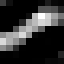

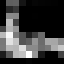

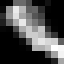

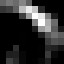

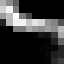

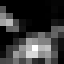

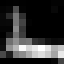

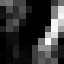

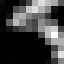

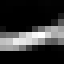

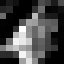

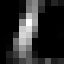

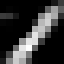

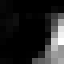

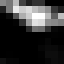

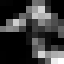

Epoch 5/5
9000/9000 [==============================] - 5s - loss: 0.2826 - acc: 0.9294 - val_loss: 0.2828 - val_acc: 0.9250

In [8]:
from keras.utils.np_utils import to_categorical

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nb_train = 10_000
model.fit(X[:nb_train], to_categorical(y[:nb_train]), validation_split=.1, epochs=5, callbacks=[KernelVisualizer()])

## Rank Which Filters Excite Each Digit Classifier the Most

This has a bug somewhere!

0


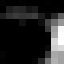

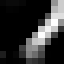

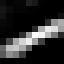

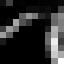

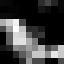

1


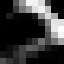

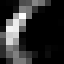

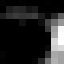

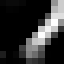

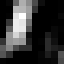

2


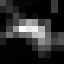

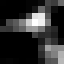

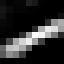

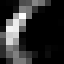

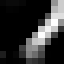

3


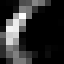

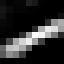

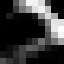

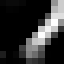

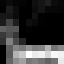

4


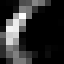

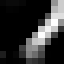

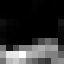

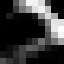

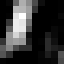

5


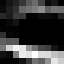

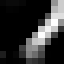

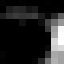

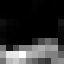

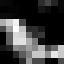

6


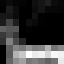

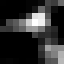

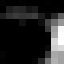

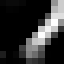

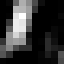

7


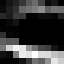

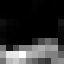

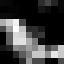

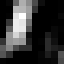

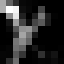

8


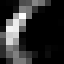

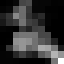

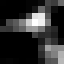

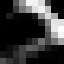

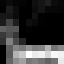

9


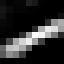

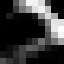

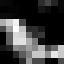

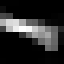

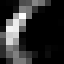

In [5]:
from skimage.measure import block_reduce

pool_factor = model.get_layer('flatten').output_shape[1] // nb_filter
W_softmax, b_softmax = model.get_layer('softmax_weights').get_weights()
W_conv, b_conv = model.get_layer('conv').get_weights()
for d in range(10):
    print(d)
    w = W_softmax[:, d]
    pooled = block_reduce(w, (pool_factor,), np.max)
    strong_idxs = np.argsort(-pooled)[:5]
    for idx in strong_idxs:
        w = W_conv[..., idx]
        img = array_to_img(w).resize(size=[64, 64])
        display(img)